# Anomaly Detection

In this project, I will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 

## 1 - Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

## 2 - Anomaly detection

### 2.1 Problem Statement

In this project, I will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

The dataset comes from Coursera thught by Andrew Ng [https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning].

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While our servers were operating, I assumed collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* I suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

I will use a Gaussian model to detect anomalous examples in my
dataset. 
* I will first start on a 2D dataset that will allow me to visualize what the algorithm is doing.
* On that dataset, I will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 
* After that, I will apply the anomaly detection algorithm to a larger dataset with many dimensions. 

### 2.2  Dataset

I will start by loading the dataset for this task. 
- I am going to loads the data into the variables `X_train`, `X_val` and `y_val` .
    - I will use `X_train` to fit a Gaussian distribution.
    - I will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples.

In [4]:
X_train = np.load("X_part1.npy")
X_val = np.load("X_val_part1.npy")
y_val = np.load("y_val_part1.npy")

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five elements of each of the variables.

In [5]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [6]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are:\n", X_val[:5])

The first 5 elements of X_val are:
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [7]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are:\n", y_val[:5])  

The first 5 elements of y_val are:
 [0 0 0 0 0]


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions.

The code below prints the shape of `X_train`, `X_val` and `y_val`.

In [8]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


In [9]:
X_train_df = pd.DataFrame(X_train, columns=['Throughput(mb/s)', 'Latency(ms)'])
X_val_df = pd.DataFrame(X_val, columns=['Throughput(mb/s)', 'Latency(ms)'])
y_val_df = pd.DataFrame(y_val, columns=['Anomaliy Label'])
val_df = X_val_df.join(y_val_df)

In [10]:
X_train_df

,Throughput(mb/s),Latency(ms)
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849
...,...,...
302,12.476629,14.459370
303,19.582573,10.411619
304,23.339868,16.298874
305,18.261188,17.978309


In [11]:
val_df

,Throughput(mb/s),Latency(ms),Anomaliy Label
0,15.790260,14.921024,0
1,13.639619,15.329955,0
2,14.865899,16.473865,0
3,13.584676,13.989306,0
4,13.464042,15.635330,0
...,...,...,...
302,0.307938,5.391413,1
303,28.541786,21.599776,1
304,19.034988,12.028949,1
305,14.375779,23.355973,1


#### Visualize your data

Before starting on any task, it is often useful to understand the data by visualizing it. 
- For this dataset, I can use a scatter plot to visualize the data (`X_train`), since it has only two properties to plot (throughput and latency).

<Axes: xlabel='Throughput(mb/s)', ylabel='Latency(ms)'>

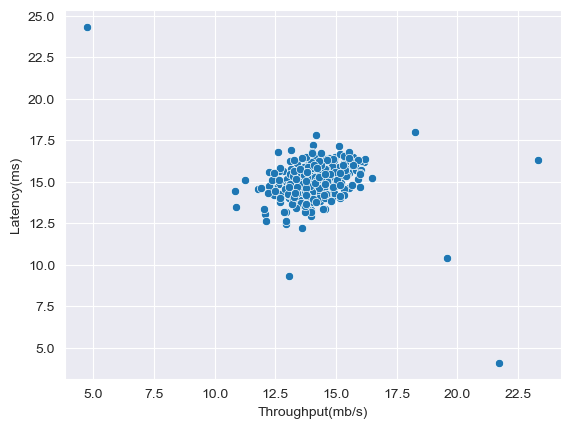

In [12]:
sns.scatterplot(data=X_train_df, x='Throughput(mb/s)', y='Latency(ms)')

### 2.3 Gaussian distribution

To perform anomaly detection, I will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$, I want to estimate the Gaussian distribution for each
of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, I need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

### 2.3.1 Estimating parameters for a Gaussian distribution

**Implementation**: 

Function `estimate_gaussian` calculates `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

I can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, I will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance I will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [13]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """
    m, n = X.shape
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)        
    return mu, var

In [14]:
# Estimating mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


Now that I have coded `estimate_gaussian`, I want to visualize the contours of the fitted Gaussian distribution. 

From the plot I can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

In [15]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [16]:
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

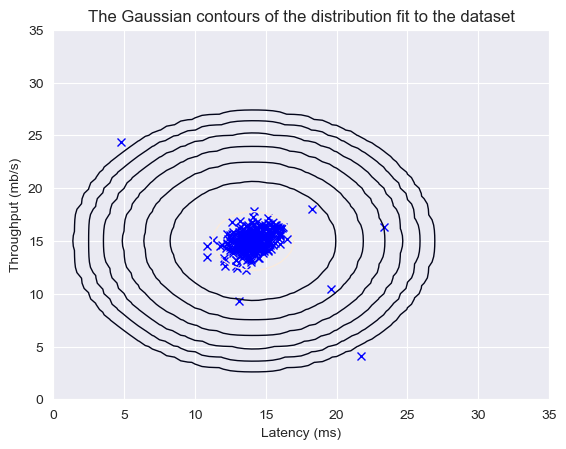

In [17]:
# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

#Plotting code 
visualize_fit(X_train, mu, var)

### 2.3.2 Selecting the threshold $\epsilon$

Now that I have estimated the Gaussian parameters, I can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, I will implement the code `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, I will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, I will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

`select_threshold` function is trying to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* In the code `select_threshold`, there is  a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 


  * If an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, I can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

**Implementation Note:** 
In order to compute $tp$, $fp$ and $fn$, I may be able to use a vectorized implementation rather than loop over all the examples.

In [18]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = (p_val < epsilon)
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [29]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


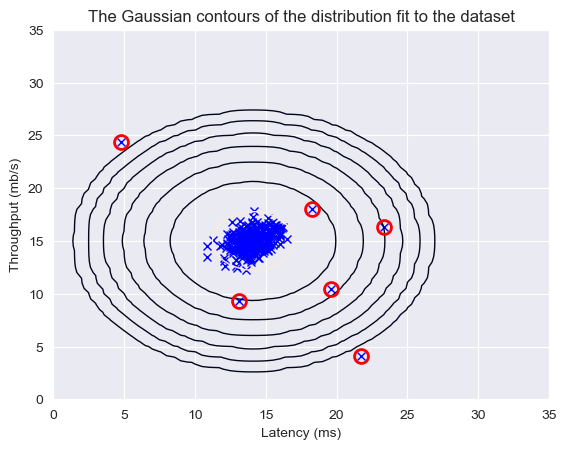

In [20]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

### 2.4 High dimensional dataset

Now, I will run the anomaly detection algorithm implemented on a more realistic and much harder dataset.

In this dataset, each example is described by 11 features, capturing many more properties of compute servers.

Let's start by loading the dataset.

- The `load_data()` function below loads the data into variables `X_train_high`, `X_val_high` and `y_val_high`
    -  `_high` is meant to distinguish these variables from the ones used in the previous part
    - I will use `X_train_high` to fit Gaussian distribution 
    - I will use `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [23]:
def load_data_multi():
    X = np.load("X_part2.npy")
    X_val = np.load("X_val_part2.npy")
    y_val = np.load("y_val_part2.npy")
    return X, X_val, y_val

In [24]:
# load the dataset
X_train_high, X_val_high, y_val_high = load_data_multi()

In [25]:
print ('The shape of X_train_high is:', X_train_high.shape)
print ('The shape of X_val_high is:', X_val_high.shape)
print ('The shape of y_val_high is: ', y_val_high.shape)

The shape of X_train_high is: (1000, 11)
The shape of X_val_high is: (100, 11)
The shape of y_val_high is:  (100,)


#### Anomaly detection 

Now, let's run the anomaly detection algorithm on this new dataset.

The code below will: 
* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train_high` from which you estimated the Gaussian parameters, as well as for the the cross-validation set `X_val_high`. 
* Finally, it will use `select_threshold` to find the best threshold $\varepsilon$. 

In [28]:
# Apply the same steps to the larger dataset

# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


## In conclusion, concerning the chosen epsilon, 117 examples are among the anomalies.